In [1]:
# import torch
# from torch_geometric.data import Data

# edge_index = torch.tensor([[0, 1, 1, 2],
#                            [1, 0, 2, 1]], dtype=torch.long)
# x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# data = Data(x=x, edge_index=edge_index)
# data

In [2]:
import sys
sys.path.append("../scripts/")
from peaks_pygdata import Patches

dataset_name = "20231107_patches_flatsky_fwhm3_radius8_noiseless"

dataset = Patches(dataset_name)

/global/cfs/cdirs/des/shubh/.conda/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[:int(len(dataset) * 0.01)]
test_dataset = dataset[int(len(dataset) * 0.999):]

print(len(train_dataset), len(test_dataset))
batch_size = 2 ** 7
print(batch_size, len(train_dataset) / batch_size)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1696 170
128 13.25


In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
true = np.array([])
for i, data in enumerate(train_dataloader):
    true = np.append(true, data.y.numpy())

true = true.reshape(-1, 6)
print(true.shape)

scaler = scaler.fit(true)

(1696, 6)


In [16]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, len(dataset[0].y))

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=6, bias=True)
)


In [17]:
import tqdm, gc

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    for data in tqdm.tqdm(train_dataloader):  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        true = torch.tensor(scaler.transform(data.y.reshape(-1, 6)))
        loss = criterion(out, true)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        del data, out, loss
        gc.collect()

def test(loader):
    model.eval()
    mse = 0
    for data in tqdm.tqdm(loader):  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        true = torch.tensor(scaler.transform(data.y.reshape(-1, 6)))
        mse += torch.sum((out - true) ** 2).item()
        del data, out
        gc.collect()
    return mse / len(test_dataset)

In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    train()
    train_mse = test(train_dataloader)
    test_mse = test(test_dataloader)
    print(f"Epoch: {epoch}, Train MSE: {train_mse}, Test MSE: {test_mse}")

  0%|          | 0/14 [00:00<?, ?it/s]

: 

: 

In [14]:
# plot predictions vs true values
import matplotlib.pyplot as plt
import numpy as np

model.eval()
out, true = np.array([]), np.array([])
for data in test_dataloader:
    out = scaler.inverse_transform(np.append(out, model(data.x, data.edge_index, data.batch).detach().numpy()))
    true = np.append(true, data.y.detach().numpy())
    del data
    gc.collect()

out = out.reshape(-1, 6)
true = true.reshape(-1, 6)
print(out.shape, true.shape)

(170, 6) (170, 6)


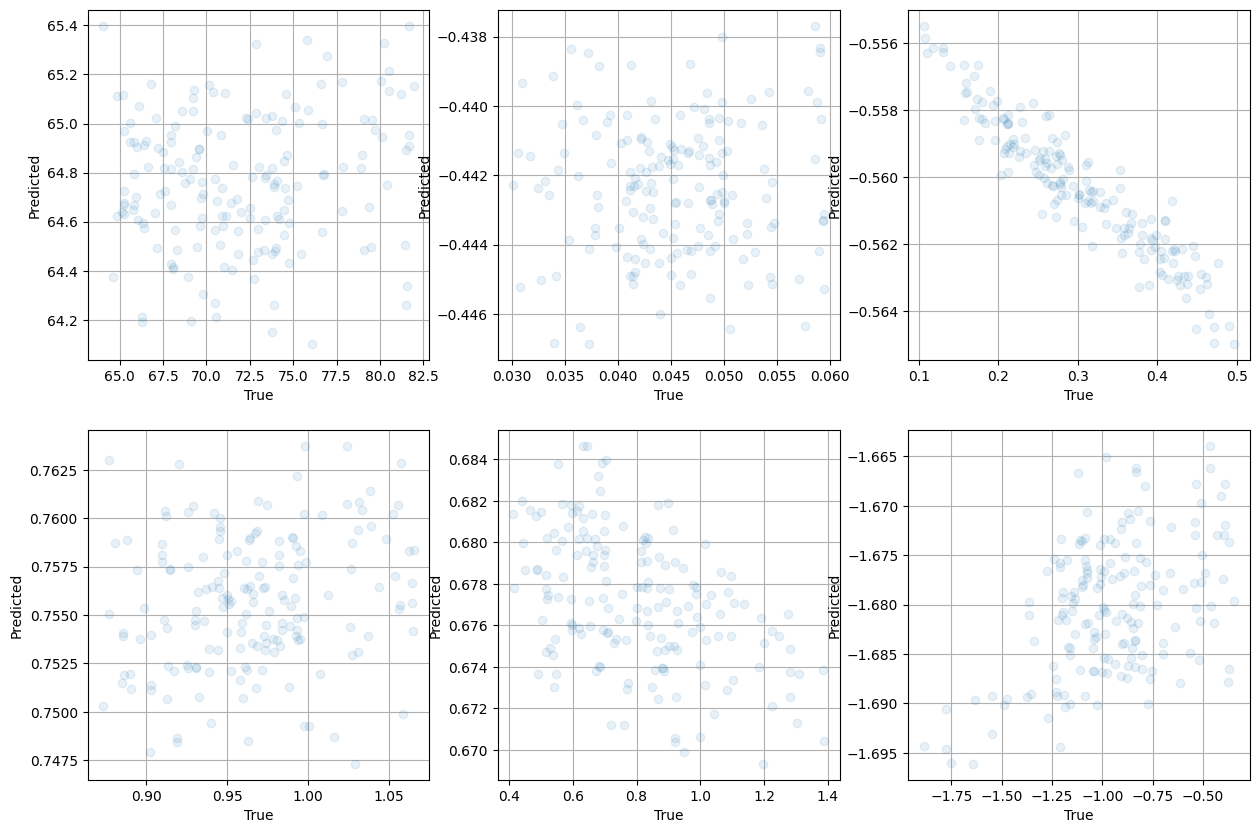

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ind, ax in enumerate(axs.flatten()):
    ax.plot(true[:, ind], out[:, ind], "o", alpha=0.1)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid()
plt.show()
plt.close()

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from torch_geometric.nn import GCN
model = GCN(in_channels=-1, hidden_channels=64, out_channels=len(dataset[0].y), \
            num_layers=3).to(device)
print(model)

cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(loader):
    model.eval()

    mse = 0
    for data in loader:
        data = data.to(device)
        out = model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        # mse error
        mse += torch.sum((out - data.y) ** 2).item()
    return mse / len(test_dataset)

In [5]:
num_epochs = 10
for epoch in range(num_epochs):
    train()
    train_mse = test(train_dataloader)
    test_mse = test(test_dataloader)
    print(f"Epoch: {epoch}, Train MSE: {train_mse}, Test MSE: {test_mse}")

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43735,0,0], thread: [32,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [76,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [27,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [42,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [43736,0,0], thread: [58,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: ope

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
